# LLM, What's the Median?

In this notebook I use reinforcement learning (via [Tinker](https://github.com/thinking-machines-lab/tinker-cookbook)) to teach an LLM to compute the median of a list.

The setup is simple:  
- The task is to take the median of a list of 15 integers sampled from 1 to 100.  
- I use `statistics.median` as the ground truth to generate data and evaluate correctness.  
- I start with a base Llama model (typically [Llama 3 8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B), with [Llama 3 1B](https://huggingface.co/meta-llama/Llama-3.2-1B) for model-size experiments).  
- I wrap this in a Tinker training loop to reward correct medians and penalize wrong ones.

In here, I *tinker* with three main pieces:
- **Data / environment**: generating lists and rewards, wiring up the prompt and `generate_distribution` helper.  
- **RL training loop**: using Tinker to fine-tune the model toward “liking” correct medians and “disliking” wrong ones.  
- **Evaluation**: measuring accuracy and failure modes under different conditions.

I also probe a few questions along the way:
1. How well does the model perform in-distribution after RL (15-length lists, values 1–100)?  
2. What happens when I shift the value range to 1–1000?  
3. What breaks (or holds up) when I double the list length from 15 to 30?  
4. How much performance drops when I shrink the model from 8B to 1B?

This notebook is mostly about understanding how far RL can push a base LLM on a very constrained, algorithmic-style task—and where it starts to struggle.

This was a part of [Trustworhty AI](https://trustworthy-ai-2025.github.io/) class at Cornell Tech.

In [ ]:
!pip install git+https://github.com/thinking-machines-lab/tinker-cookbook.git

In [ ]:
import os
os.environ["TINKER_API_KEY"] = TINKER_API_KEY

import asyncio
import random
import statistics
from functools import partial
from typing import Optional
import pandas as pd

import numpy as np
import re
import tinker
from tinker_cookbook import renderers
from tinker_cookbook.completers import TinkerTokenCompleter
from tinker_cookbook.rl.data_processing import assemble_training_data, compute_advantages
from tinker_cookbook.rl.problem_env import ProblemEnv, ProblemGroupBuilder
from tinker_cookbook.rl.rollouts import do_group_rollout
from tinker_cookbook.rl.types import EnvGroupBuilder, RLDataset
from tinker_cookbook.tokenizer_utils import get_tokenizer
from tinker_cookbook.hyperparam_utils import get_lr

In [ ]:
# model_name = "Qwen/Qwen3-4B-Instruct-2507"
# renderer_name = "qwen3"

model_name = "meta-llama/Llama-3.1-8B-Instruct"
renderer_name = "llama3"

# learning_rate = get_lr(model_name) #0.0002856415043086949
learning_rate = 1e-5

def generate_distribution(
        min_value: int,
        max_value: int,
        count: int,
        generator: Optional[random.Random] = None,
    ) -> dict:
    assert count >= 1
    assert min_value <= max_value

    if generator is None:
        generator = random

    target_median = generator.randint(min_value + 10, max_value - 10)

    lower_half_count = count // 2
    upper_half_count = count - lower_half_count

    values = []

    for _ in range(lower_half_count):
        value = generator.randint(min_value, target_median - 1)
        values.append(value)

    for _ in range(upper_half_count):
        value = generator.randint(target_median, max_value)
        values.append(value)

    generator.shuffle(values)

    output_data = {
        "parameters": {
            "min_value": min_value,
            "max_value": max_value,
            "count": count,
            "target_median": target_median,
        },
        "values": values,
        "median": statistics.median(values),
        "mean": statistics.mean(values),
    }

    return output_data

SYSTEM_PROMPT = (
    "Given the following data, consisting of {list_length} numbers, you will be asked "
    "to compute the median. Data: {data}. What is the median of these numbers? "
    "Feel free to think step-by-step. After reasoning, please respond with the median "
    "only (a single number)."
)

## Training set up

In [185]:
class MedianEnv(ProblemEnv):
    def __init__(self, numbers: list[int], renderer: renderers.Renderer, fewshot: list[dict]):
        super().__init__(renderer, convo_prefix=fewshot)
        self.numbers = numbers
        self.correct_median = statistics.median(numbers)

    def get_question(self) -> str:
        data_str = ", ".join(str(n) for n in self.numbers)
        return SYSTEM_PROMPT.format(
            list_length=len(self.numbers),
            data=data_str,
        )

    def check_answer(self, sample_str: str) -> bool:
        try:
            clean = sample_str.replace(",", " ")
            matches = re.findall(r"[-+]?\d*\.?\d+", clean)
            if not matches:
                return False

            parsed = float(matches[-1])
            expected = float(self.correct_median)

            if len(self.numbers) % 2 == 1 and "average" in sample_str.lower():
                return False

            return abs(parsed - expected) < 0.01
        except (ValueError, TypeError):
            return False

    def check_format(self, sample_str: str) -> bool:
        return True

    def get_reference_answer(self) -> str:
        m = self.correct_median
        return str(int(m)) if m == int(m) else str(m)


class MedianDataset(RLDataset):
    def __init__(
        self,
        batch_size: int,
        group_size: int,
        renderer: renderers.Renderer,
        fewshot: list[dict],
        n_batches: int = 100,
        min_value: int = 1,
        max_value: int = 100,
        list_length: int = 15
    ):
        self.batch_size = batch_size
        self.group_size = group_size
        self.renderer = renderer
        self.fewshot = fewshot
        self.n_batches = n_batches
        self.min_value = min_value
        self.max_value = max_value
        self.list_length = list_length

    def get_batch(self, index: int) -> list[EnvGroupBuilder]:
        rng = random.Random(index)

        batch = []
        for _ in range(self.batch_size):
            problem = generate_distribution(
                self.min_value,
                self.max_value,
                self.list_length,
                generator=rng
            )

            env_builder = ProblemGroupBuilder(
                env_thunk=partial(
                    MedianEnv,
                    numbers=problem["values"],
                    renderer=self.renderer,
                    fewshot=self.fewshot
                ),
                num_envs=self.group_size
            )
            batch.append(env_builder)

        return batch

    def __len__(self) -> int:
        return self.n_batches

In [186]:
def create_fewshot_examples() -> list[dict]:
    return [
        {
            "role": "user",
            "content": "What is the median of these numbers: 10, 30, 20?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 10, 20, 30\n20"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 5, 15, 10, 20?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 5, 10, 15, 20\n12.5"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 1, 2, 50, 99, 100?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 1, 2, 50, 99, 100\n50"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15\nThere are 15 numbers. The median is the 8th number.\nThe 8th number is 8.\n8"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 8, 2, 5, 9, 1, 3, 7?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 1, 2, 3, 5, 7, 8, 9\nThere are 7 numbers. The median is the 4th number.\nThe 4th number is 5.\n5"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 12, 45, 2, 8, 15, 30, 10, 5, 20?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 2, 5, 8, 10, 12, 15, 20, 30, 45\nThere are 9 numbers. The median is the 5th number.\nThe 5th number is 12.\n12"
        },
        {
            "role": "user",
            "content": "What is the median of these numbers: 12, 45, 2, 8, 15, 30, 10, 5, 20, 25?"
        },
        {
            "role": "assistant",
            "content": "Sorted: 2, 5, 8, 10, 12, 15, 20, 25, 30, 45\nThere are 10 numbers (even). The median is the average of the 5th and 6th numbers.\n5th number: 12\n6th number: 15\nAverage: (12 + 15) / 2 = 13.5\n13.5"
        }
    ]


async def train_step(
    training_client: tinker.TrainingClient,
    data: list[tinker.Datum],
    learning_rate: float
) -> None:
    # Clean data
    clean_data = [
        tinker.Datum(
            model_input=d.model_input,
            loss_fn_inputs={k: v for k, v in d.loss_fn_inputs.items() if k != "mask"}
        )
        for d in data
    ]

    # Forward-backward pass
    fwd_bwd_future = await training_client.forward_backward_async(
        clean_data,
        loss_fn="importance_sampling"
    )
    await fwd_bwd_future.result_async()

    # Optimizer step
    optim_future = await training_client.optim_step_async(
        tinker.AdamParams(
            learning_rate=learning_rate,
            beta1=0.9,
            beta2=0.95,
            eps=1e-8
        )
    )
    await optim_future.result_async()

In [191]:
async def train_median_model(
    model_name=model_name,
    n_batches=50,
    batch_size=16,
    group_size=4,
    max_tokens=256,
    learning_rate=learning_rate,
    lora_rank=32,
    max_value=100,
    list_length=15
):
    print(f"Training {model_name} | batch={batch_size}, group={group_size}, tokens={max_tokens}, max_value={max_value}, list_length={list_length}")

    # Setup
    tokenizer = get_tokenizer(model_name)
    renderer = renderers.get_renderer(renderer_name, tokenizer=tokenizer)
    fewshot = create_fewshot_examples()

    dataset = MedianDataset(
        batch_size=batch_size,
        group_size=group_size,
        renderer=renderer,
        fewshot=fewshot,
        n_batches=n_batches,
        min_value=1,
        max_value=max_value,
        list_length=list_length
    )

    service_client = tinker.ServiceClient()
    training_client = await service_client.create_lora_training_client_async(
        model_name, rank=lora_rank
    )
    sampling_client = await training_client.save_weights_and_get_sampling_client_async()

    for i_batch in range(n_batches):
        if i_batch % 10 == 0:
            print(f"Batch {i_batch:3d}/{n_batches}")
        env_builders = dataset.get_batch(i_batch)

        policy = TinkerTokenCompleter(
            sampling_client,
            max_tokens=max_tokens,
            temperature=0.3
        )

        trajectory_groups = await asyncio.gather(*[
            do_group_rollout(b, policy) for b in env_builders
        ])

        # Compute rewards and advantages
        all_rewards = [r for tg in trajectory_groups for r in tg.get_total_rewards()]
        advantages = compute_advantages(trajectory_groups)

        data, _ = assemble_training_data(trajectory_groups, advantages)

        await train_step(training_client, data, learning_rate)

        sampling_client = await training_client.save_weights_and_get_sampling_client_async()

        # Log progress
        mean_reward = np.mean(all_rewards)
        accuracy = np.mean([r > 0 for r in all_rewards])
        print(f"Batch {i_batch:3d}/{n_batches}: reward={mean_reward:.3f}, acc={accuracy:.1%}")

    return sampling_client, renderer, fewshot


async def eval_median_accuracy(
    sampling_client: tinker.SamplingClient,
    renderer: renderers.Renderer,
    fewshot: list[dict],
    min_value: int = 1,
    max_value: int = 100,
    list_length: int = 15,
    n_problems: int = 100,
    seed: int = 9999,
    max_tokens: int = 256,
):
    rng = random.Random(seed)
    test_problems = [
        generate_distribution(min_value, max_value, list_length, rng)
        for _ in range(n_problems)
    ]

    # Deterministic eval
    params = tinker.SamplingParams(
        max_tokens=max_tokens,
        temperature=0.0,
        top_p=1.0,
    )

    prompts = []
    decoded_prompts = []

    for problem in test_problems:
        numbers_str = ", ".join(str(n) for n in problem["values"])
        system_prompt = SYSTEM_PROMPT.format(
            list_length=len(problem["values"]),
            data=numbers_str,
        )

        conversation = fewshot + [{"role": "user", "content": system_prompt}]
        prompt = renderer.build_generation_prompt(conversation)
        prompts.append(prompt)
        decoded_prompts.append(conversation)

    responses = await asyncio.gather(*[
        sampling_client.sample_async(prompt=p, num_samples=1, sampling_params=params)
        for p in prompts
    ])

    correct = 0
    results_data = []

    for i, response in enumerate(responses):
        response_text = renderer.tokenizer.decode(response.sequences[0].tokens)
        problem = test_problems[i]
        expected = float(problem["median"])

        parsed_val = None
        is_correct = False

        try:
            clean_text = response_text.replace(",", " ")
            matches = re.findall(r"[-+]?\d*\.?\d+", clean_text)
            if matches:
                parsed_val = float(matches[-1])
                if abs(parsed_val - expected) < 0.01:
                    is_correct = True
        except (ValueError, IndexError):
            pass

        if is_correct:
            correct += 1

        results_data.append({
            "is_correct": is_correct,
            "input_list": str(problem["values"]),
            "expected": expected,
            "parsed": parsed_val,
            "model_response": response_text,
            "full_prompt": decoded_prompts[i],
        })

    accuracy = correct / len(test_problems)
    df = pd.DataFrame(results_data)
    return accuracy, df

# Experiment 1: Calculating the median on 15 numbers between 1-100

The model achieves **72%** accuracy on the in-distribution task (15 numbers, range 1-100). Training accuracy fluctuates between 70-98% and runs higher than test accuracy, likely because training uses temperature 0.3 while eval uses 0.0.

**What's breaking:** Looking at the failures below, the model consistently sorts correctly but fails at position counting. In multiple cases, it picks the wrong index (e.g., choosing position 8 when it should identify the 8th element), or incorrectly averages two numbers even when the list has odd length. RL reinforced sorting strongly, but the "find the middle position" step remains fragile.

In [201]:
sampling_client, renderer, fewshot = await train_median_model(
    model_name=model_name,
    n_batches=20,
    max_value = 100,
    list_length= 15
)

accuracy, df_results = await eval_median_accuracy(
    sampling_client, renderer, fewshot,
    max_value=100,
    list_length=15,
    n_problems=100
)
print(f"In-distribution accuracy: {accuracy:.1%}")

Training meta-llama/Llama-3.1-8B-Instruct | batch=16, group=4, tokens=256, max_value=100, list_length=15
Batch   0/20
Batch   0/20: reward=0.953, acc=95.3%
Batch   1/20: reward=0.828, acc=82.8%
Batch   2/20: reward=0.797, acc=79.7%
Batch   3/20: reward=0.797, acc=79.7%
Batch   4/20: reward=0.827, acc=82.8%
Batch   5/20: reward=0.969, acc=96.9%
Batch   6/20: reward=0.938, acc=93.8%
Batch   7/20: reward=0.984, acc=98.4%
Batch   8/20: reward=0.891, acc=89.1%
Batch   9/20: reward=0.828, acc=82.8%
Batch  10/20
Batch  10/20: reward=0.969, acc=96.9%
Batch  11/20: reward=0.750, acc=75.0%
Batch  12/20: reward=0.984, acc=98.4%
Batch  13/20: reward=0.938, acc=93.8%
Batch  14/20: reward=0.922, acc=92.2%
Batch  15/20: reward=0.922, acc=92.2%
Batch  16/20: reward=0.703, acc=70.3%
Batch  17/20: reward=0.969, acc=96.9%
Batch  18/20: reward=0.859, acc=85.9%
Batch  19/20: reward=0.969, acc=96.9%
In-distribution accuracy: 72.0%


### Where did the model fail?

Sample failures show a clear pattern: the model averages two numbers even for odd-length lists, or miscounts positions after sorting. It learned sorting behavior but not reliable indexing.

In [202]:
wrong = df_results[~df_results["is_correct"]].head(5)
for i, row in wrong.iterrows():
    print("----")
    print("input_list :", row["input_list"])
    print("expected   :", row["expected"])
    print("parsed     :", row["parsed"])
    print("response   :", row["model_response"])

----
input_list : [71, 56, 24, 73, 96, 4, 83, 72, 89, 85, 31, 34, 93, 76, 86]
expected   : 73.0
parsed     : 73.5
response   : First, let's sort the numbers in ascending order: 4, 24, 31, 34, 56, 71, 72, 73, 76, 83, 85, 86, 89, 93, 96

Since there are 15 numbers (an odd count), the median is the middle number. 
15 numbers / 2 = 7.5
The 8th and 9th numbers will determine the median, as they are equidistant from the midpoint and form the middle value.

8th number: 73
9th number: 76 

The median of these numbers is: 73.5<|eot_id|>
----
input_list : [96, 68, 13, 60, 14, 68, 28, 31, 68, 12, 35, 46, 98, 68, 63]
expected   : 60.0
parsed     : 46.0
response   : Sorted: 12, 13, 14, 28, 30, 31, 35, 46, 60, 63, 68, 68, 68, 68, 98
There are 15 numbers (odd). The median is the 8th number.
The 8th number is 46.<|eot_id|>
----
input_list : [26, 34, 38, 35, 66, 55, 7, 28, 42, 84, 2, 28, 22, 12, 75]
expected   : 34.0
parsed     : 28.0
response   : Sorted: 2, 7, 12, 22, 26, 28, 28, 34, 35, 38, 42, 55, 6

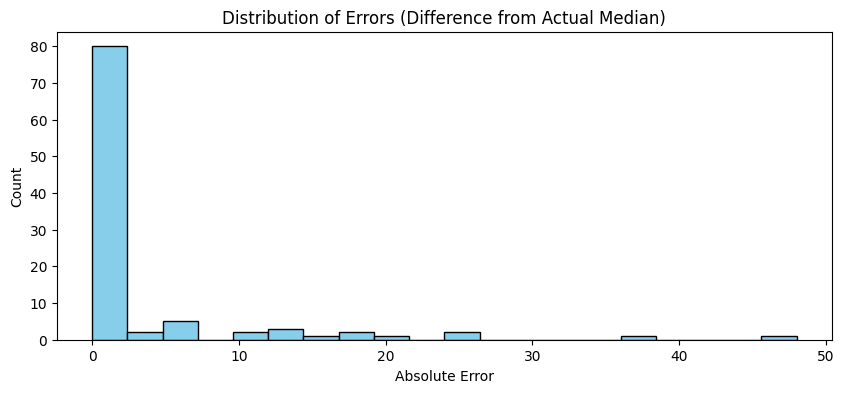

In [203]:
import matplotlib.pyplot as plt
valid_results = df_results.dropna(subset=['parsed'])
errors = abs(valid_results['parsed'] - valid_results['expected'])

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Errors (Difference from Actual Median)')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

## Experiment 2: Inferring on 15 numbers between 1-1000 

Accuracy drops to **53%** when testing on values 1-1000 (trained only on 1-100). That's a 19% drop from in-distribution performance.

**Why this matters:** The error distribution shape stays similar to the 1-100 case, suggesting the model learned "median-like" behavior rather than the underlying algorithm. It likely memorized patterns specific to two-digit numbers instead of generalizing the numeric reasoning. Scaling values by 10x exposed that the model doesn't understand magnitude-invariant sorting.

In [204]:
accuracy, df_results = await eval_median_accuracy(
    sampling_client, renderer, fewshot,
    max_value=1000,
    list_length=15,
    n_problems=100
)
print(f"1-1000 accuracy: {accuracy:.1%}")

1-1000 accuracy: 53.0%


----
input_list : [946, 34, 582, 924, 47, 59, 771, 534, 400, 1, 58, 45, 700, 864, 60]
expected   : 400.0
parsed     : 534.0
response   : Step-by-step:

Sorted data: 1, 34, 45, 47, 58, 59, 60, 400, 534, 582, 700, 771, 864, 924, 946

There are 15 numbers (odd). The median is the middle number.

Position of the median: (15 + 1) / 2 = 8

The 8th number is the median.
The 8th number is 534.

 Median: 534<|eot_id|>
----
input_list : [553, 998, 808, 986, 983, 977, 970, 144, 989, 978, 981, 750, 149, 416, 209]
expected   : 970.0
parsed     : 977.0
response   : Sorted: 144, 209, 416, 553, 750, 808, 970, 977, 978, 981, 983, 986, 989, 998 

There are 15 numbers (odd). The median is the 8th number.
The 8th number is 977.<|eot_id|>
----
input_list : [992, 303, 24, 91, 254, 381, 735, 936, 145, 768, 970, 249, 785, 704, 752]
expected   : 704.0
parsed     : 381.0
response   : To compute the median, I will first sort the numbers in ascending order:

24, 91, 145, 203, 249, 254, 303, 381, 704, 735, 752, 76

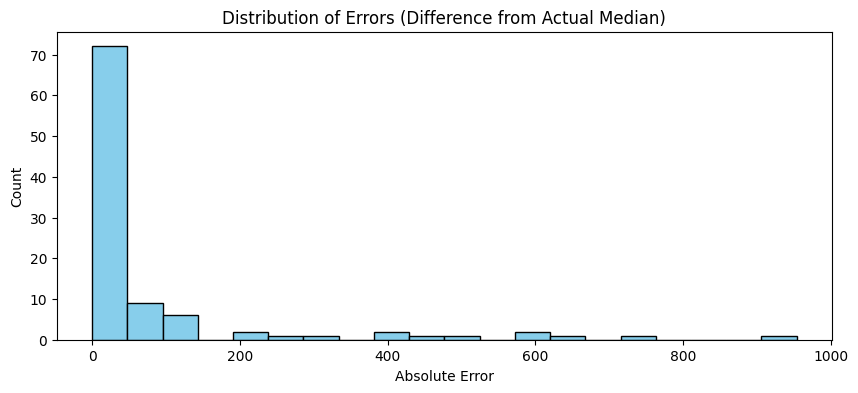

In [205]:
wrong = df_results[~df_results["is_correct"]].head(5)
for i, row in wrong.iterrows():
    print("----")
    print("input_list :", row["input_list"])
    print("expected   :", row["expected"])
    print("parsed     :", row["parsed"])
    print("response   :", row["model_response"])

valid_results = df_results.dropna(subset=['parsed'])
errors = abs(valid_results['parsed'] - valid_results['expected'])

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Errors (Difference from Actual Median)')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

## Experiment 3: Inferring on 30 numbers between 1-100

Accuracy drops to **37%** when doubling the list length from 15 to 30 elements. This is the sharpest degradation of any out-of-distribution test with 35% drop.

**The key insight:** The model still sorts correctly in most cases, but breaks when counting to position 15 or 16 in a longer sequence. List length matters more than value range. Doubling the number of elements hurt performance twice as much as making values 10x larger (Experiment 2). The algorithmic bottleneck isn't handling large numbers; it's maintaining position tracking in longer sequences.

In [206]:
accuracy, df_results = await eval_median_accuracy(
    sampling_client, renderer, fewshot,
    max_value=100,
    list_length=30,
    n_problems=100
)
print(f"Longer length (30) accuracy: {accuracy:.1%}")

Longer length (30) accuracy: 37.0%


----
input_list : [8, 49, 20, 100, 26, 93, 5, 3, 7, 98, 7, 19, 25, 82, 10, 62, 21, 6, 25, 63, 10, 34, 52, 46, 22, 18, 36, 86, 77, 33]
expected   : 25.5
parsed     : 25.0
response   : Sorted data: 3, 5, 6, 7, 7, 8, 10, 10, 15, 18, 19, 20, 21, 22, 25, 25, 26, 33, 34, 36, 46, 49, 52, 62, 63, 77, 82, 86, 93, 98
Since there are 30 numbers, the median is the 15th number.
15th number: 25<|eot_id|>
----
input_list : [51, 97, 12, 57, 85, 26, 85, 1, 15, 51, 18, 87, 34, 23, 62, 34, 44, 40, 33, 51, 63, 85, 38, 91, 45, 17, 34, 26, 14, 8]
expected   : 39.0
parsed     : 54.0
response   : Here's the step-by-step reasoning:

**Arrange the data in ascending order:**
1, 8, 12, 14, 15, 17, 18, 23, 26, 26, 27 (no 27 is provided, switching 12 and 14) 33, 34, 34, 34, 38, 40, 44, 45, 51, 51, 51, 57, 62, 63, 85, 85, 85, 87, 91, 97

**Since there are 30 numbers (an even number), the median is the average of the 15th and 16th numbers.**

15th number: 51
16th number: 57

**Calculate the median:**
Median = (51 + 5

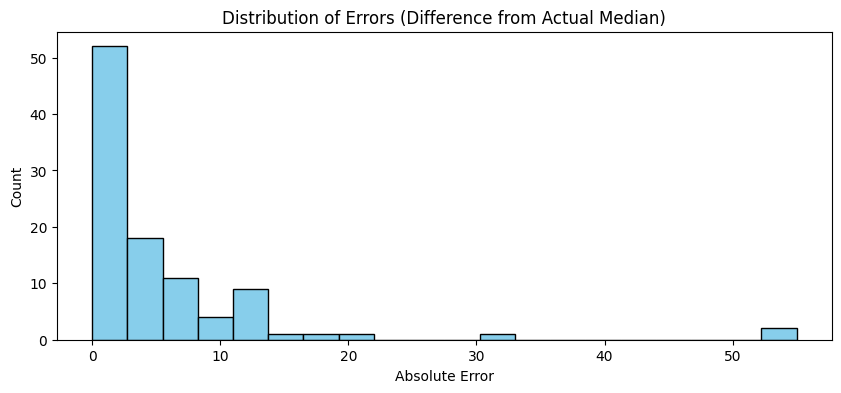

In [207]:
wrong = df_results[~df_results["is_correct"]].head(5)
for i, row in wrong.iterrows():
    print("----")
    print("input_list :", row["input_list"])
    print("expected   :", row["expected"])
    print("parsed     :", row["parsed"])
    print("response   :", row["model_response"])

valid_results = df_results.dropna(subset=['parsed'])
errors = abs(valid_results['parsed'] - valid_results['expected'])

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Errors (Difference from Actual Median)')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

## Experiment 4: Using a 1B Param Model for the same task

Retraining with a 1B parameter model instead of 8B drops accuracy to **32%**.

**What's surprising:** Training logs show the model barely improves during RL, fluctuating around 3% accuracy throughout training. Yet it achieves 32% at eval time. This gap likely comes from the few-shot examples providing a template the model can partially follow even without meaningful RL improvement. The 8B to 1B parameter reduction hurts more than any distribution shift. Smaller models can't hold the procedural steps (sort, find length, calculate position, extract value) reliably in context.

In [199]:
model_name1B = "meta-llama/Llama-3.2-1B"

sampling_client1B, renderer1B, fewshot1B = await train_median_model(
    model_name=model_name1B,
    n_batches=10
)

accuracy1b, df_results1b = await eval_median_accuracy(
    sampling_client1B, renderer1B, fewshot1B,
    min_value=1, max_value=100, list_length=15,
    n_problems=50, seed=9999
)
print(f"1B Param model accuracy: {accuracy:.1%}")

Training meta-llama/Llama-3.2-1B | batch=16, group=4, tokens=256, max_value=100, list_length=15
Batch   0/10
Batch   0/10: reward=-0.069, acc=3.1%
Batch   1/10: reward=-0.100, acc=0.0%
Batch   2/10: reward=-0.069, acc=3.1%
Batch   3/10: reward=-0.069, acc=3.1%
Batch   4/10: reward=-0.069, acc=3.1%
Batch   5/10: reward=-0.069, acc=3.1%
Batch   6/10: reward=-0.022, acc=7.8%
Batch   7/10: reward=-0.084, acc=1.6%
Batch   8/10: reward=-0.037, acc=6.2%
Batch   9/10: reward=-0.069, acc=3.1%
1B Param model accuracy: 32.0%


----
input_list : [10, 6, 64, 33, 7, 86, 54, 3, 5, 7, 96, 25, 93, 36, 100]
expected   : 33.0
parsed     : 77.0
response   : Sorted: 10, 6, 64, 7, 7, 89, 36, 86, 54, 25, 3, 5, 25, 100
There are 15 numbers, and 6 of them are equal (1,7, 7, 89).
Median: (64 + 86)/2 = 77.5
77VERTISE RecognitionExceptionاجع kẻ này irregular (bẩn tiềm)
77 운영자liğinde_FRAMEBUFFER EXCEPTIONDE zákaz lái xe hảo hình
77 broadcasterخش thiểu cổ phản mặc cả
77 pathnameTIMER televăng trải thời kỳ là lúc máoser trúng vô lợi
77 injunctionBIRT территорír cứu trợ triuvàt
77 leaseLAM bố chuyên là kiêm lai thời điểm khai phiếu là dửng người
77 free filmrière âm nhạc phái lá hướng hànなかったうなら君様助っ人しなきゃぼっこんななはり君様考えてほときましせやぁぁ!!!
77 presidentREV nhà nước trong đại diện
77 lecturera receberESPN chinh phủ
77 exception kortly người bị ưu khê
77 estaterері đồng bóng bóng vietnam cưới
77 railroadåiliar phần

----
input_list : [71, 56, 24, 73, 96, 4, 83, 72, 89, 85, 31, 34, 93, 76, 86]
expected   : 73.0
parsed     : 3.0
response   : So

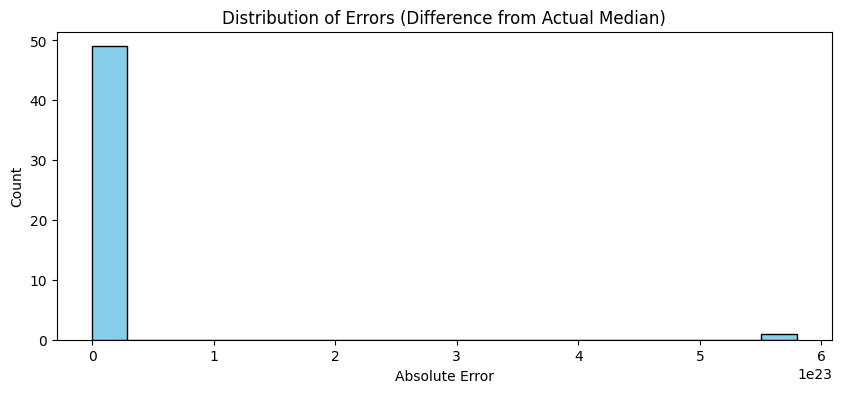

In [200]:
wrong1b = df_results1b[~df_results1b["is_correct"]].head(5)
for i, row in wrong1b.iterrows():
    print("----")
    print("input_list :", row["input_list"])
    print("expected   :", row["expected"])
    print("parsed     :", row["parsed"])
    print("response   :", row["model_response"])

valid_results = df_results1b.dropna(subset=['parsed'])
errors = abs(valid_results['parsed'] - valid_results['expected'])

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Errors (Difference from Actual Median)')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.show()

## What Did I Learn?

**RL can teach algorithmic tasks, but the learning is shallow.**  
The model achieves 72% on median-finding, which sounds decent. But every out-of-distribution test reveals it didn't learn the algorithm; instead it learned a fragile approximation. This pattern matters for building products: RL'd models will seem good in testing, then fail unexpectedly in production when conditions shift slightly.

**The failure modes are predictable and ranked.**  
Three clear lessons from the degradation patterns:
1. **Range shifts** (1-100 → 1-1000): 19% accuracy drop. Numeric reasoning doesn't transfer across scales.
2. **Length shifts** (15 → 30 elements): 35% accuracy drop. Worst generalization failure. Position counting breaks first.
3. **Model size** (8B -> 1B params): 40% accuracy drop. Outweighs any distribution shift.

**RL teaches vibes, not logic.**  
The model learned to sort (that behavior is consistent across all failures), but not to reliably count positions or handle edge cases (even/odd length). It pattern-matched on training data rather than internalizing the algorithm.

For production: either keep tasks tightly in-distribution, or verify outputs with rule-based checks.

**What would I try next?**  
- More RL iterations: maybe 100+ batches would solidify the logic instead of 20
- Synthetic data augmentation during training (vary list lengths 10-20, ranges 1-500) to force generalization
- Chain-of-thought in training examples (force explicit "count to position N" steps)  
- Compare to supervised fine-tuning baseline—is RL even the right approach for algorithmic tasks?

**The takeaway for building with AI:**  
RL is useful for optimizing subjective qualities in bounded spaces (tone, conciseness, style). For algorithmic correctness, it's risky. The model will give you 70-80% accuracy and look production-ready, but the 20-30% failure rate will be systematic and surprising. If you need reliable algorithms, write them in code—don't hope RL discovers them.

<!--

## Q2. Out of distribution performance for 1-1000


## Q3. Out of distribution performance for length 30


## Q4. Model size decrease -->
